Estimating empirical error terms

In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import arch
import datetime as dt

In [2]:
spx = pd.read_csv('^GSPC.csv', index_col=0)[1500:]
spx.index = pd.to_datetime(spx.index)
spx = spx.asfreq(freq='BMS', method='pad')

In [3]:
spx['monthly_chg'] = spx['Adj Close'].pct_change()

In [4]:
print(spx)

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
1934-02-01    11.460000    11.460000    11.460000    11.460000    11.460000   
1934-03-01    10.720000    10.720000    10.720000    10.720000    10.720000   
1934-04-02    10.760000    10.760000    10.760000    10.760000    10.760000   
1934-05-01    10.460000    10.460000    10.460000    10.460000    10.460000   
1934-06-01     9.380000     9.380000     9.380000     9.380000     9.380000   
...                 ...          ...          ...          ...          ...   
2020-09-01  3507.439941  3528.030029  3494.600098  3526.649902  3526.649902   
2020-10-01  3385.870117  3397.179932  3361.389893  3380.800049  3380.800049   
2020-11-02  3296.199951  3330.139893  3279.739990  3310.239990  3310.239990   
2020-12-01  3645.870117  3678.449951  3645.870117  3662.449951  3662.449951   
2021-01-01  3733.270020  3760.199951  3726.879883  3

In [5]:
df, loc, scale = stats.t.fit(spx['monthly_chg'][1:])
loc_norm, scale_norm = stats.norm.fit(spx['monthly_chg'][1:])

In [6]:
normal_sample =  stats.norm.rvs(loc_norm, scale_norm, size=10000000)

In [7]:
sample = stats.t.rvs(df, loc, scale, size=10000000)

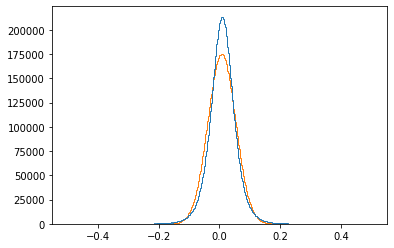

In [8]:
plt.hist(x=(sample, normal_sample), bins=500, range=[-0.5, .5], histtype='step', )
plt.show()

Simulating market with t-distributions

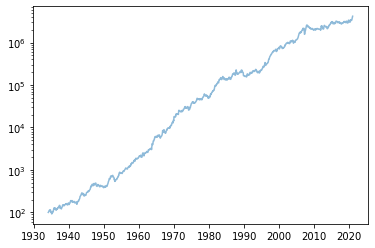

In [15]:
#years = 60
#t_months = 12
periods = len(spx)

market = np.empty((periods, 100))

num_sims = 1

for j in range(num_sims):
    market_sample = stats.t.rvs(df, loc, scale, size=periods)
    market[0, j] = 100
    for i, err in enumerate(market_sample, start=1):
        if i < (periods):
            market[i, j] = market[i-1, j]*(1+err)
        

market = pd.DataFrame(market, index=spx.index)
plt.plot(market, alpha=.5)
plt.yscale('log')
plt.show()

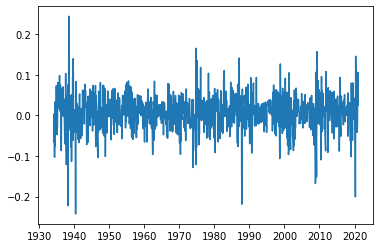

In [298]:
plt.plot(spx['monthly_chg'])
plt.show()

In [275]:
(market[-1, 0]/market[0, 0])**(1/60)-1

KeyError: (-1, 0)

Fitting GARCH model

In [303]:
model=arch.arch_model(spx['monthly_chg'][1:]*100, vol='Garch', p=2, o=0, q=2, dist='studentst')
results=model.fit()
print(results.summary())

Iteration:      1,   Func. Count:      9,   Neg. LLF: 4595.732181639641
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4381.495146088817
Iteration:      3,   Func. Count:     29,   Neg. LLF: 3120.6383266355065
Iteration:      4,   Func. Count:     39,   Neg. LLF: 2992.1428762673804
Iteration:      5,   Func. Count:     48,   Neg. LLF: 2985.245447914863
Iteration:      6,   Func. Count:     57,   Neg. LLF: 3043.740084776041
Iteration:      7,   Func. Count:     66,   Neg. LLF: 2970.379051109556
Iteration:      8,   Func. Count:     74,   Neg. LLF: 2973.003048490147
Iteration:      9,   Func. Count:     83,   Neg. LLF: 2970.292597887971
Iteration:     10,   Func. Count:     92,   Neg. LLF: 2973.9466481880636
Iteration:     11,   Func. Count:    102,   Neg. LLF: 2970.2023800459683
Iteration:     12,   Func. Count:    110,   Neg. LLF: 2970.202046716123
Iteration:     13,   Func. Count:    118,   Neg. LLF: 2970.202030012783
Iteration:     14,   Func. Count:    125,   Neg. LLF: 2970.2

In [304]:
market_sample = []
t_days = 12
years = 60
periods = t_days*years
for i in range(years):
    forecasts = results.forecast(horizon=periods, method='simulation', simulations=1)
    sims = forecasts.simulations
    sims = [sim[0]/100 for sim in sims.values[-1,:,:].T]
    market_sample.extend(sims)
    

#lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=1)
#plt.show()


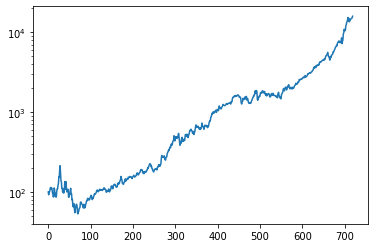

In [305]:
market = np.empty((periods, 100))

num_sims = 1


for j in range(num_sims):
    #market_sample = stats.t.rvs(df, loc, scale, size=252*years)
    market[0, j] = 100
    for i, err in enumerate(market_sample, start=1):
        if i < (periods):
            market[i, j] = market[i-1, j]*(1+err)
        
plt.plot(market[:, 0:num_sims])
plt.yscale('log')
plt.show()

In [306]:
diff = pd.DataFrame(market_sample)

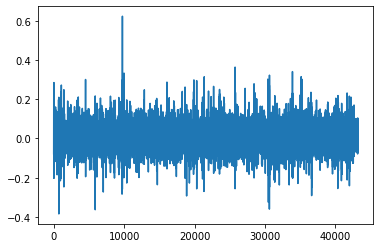

In [307]:
plt.plot(diff)
plt.show()

In [309]:
print(len(market_sample))

43200


Using pyflux

In [1208]:
import pyflux as pf
returns = pd.DataFrame(spx['daily_chg'][1:]*100, columns=['Returns'])
skewt_model = pf.SEGARCHM(p=1, q=1, data=returns)
x = skewt_model.fit()
x.summary()

AttributeError: 'DataFrame' object has no attribute 'ix'

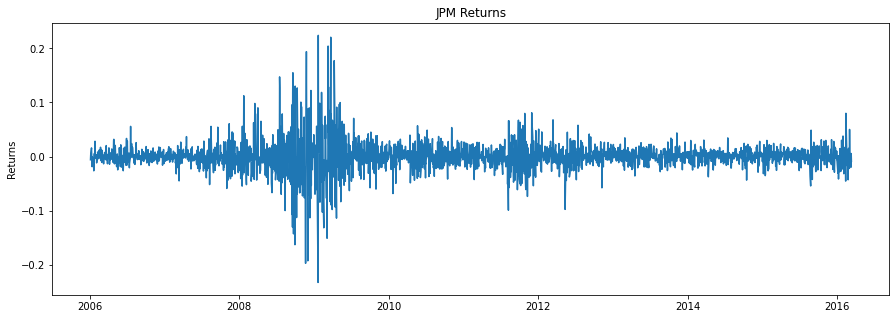

In [1210]:
import numpy as np
import pyflux as pf
import pandas as pd
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

jpm = DataReader('JPM',  'yahoo', datetime(2006,1,1), datetime(2016,3,10))
returns = pd.DataFrame(np.diff(np.log(jpm['Adj Close'].values)))
returns.index = jpm.index.values[1:jpm.index.values.shape[0]]
returns.columns = ['JPM Returns']

plt.figure(figsize=(15,5));
plt.plot(returns.index,returns);
plt.ylabel('Returns');
plt.title('JPM Returns');

In [1212]:
skewt_model = pf.SEGARCH(p=1, q=1, data=returns, target='JPM Returns')
x = skewt_model.fit()
x.summary()

SEGARCH(1,1)                                                                                              
======================================================= ==================================================
Dependent Variable: JPM Returns                         Method: MLE                                       
Start Date: 2006-01-05 00:00:00                         Log Likelihood: 6664.2753                         
End Date: 2016-03-10 00:00:00                           AIC: -13316.5506                                  
Number of observations: 2562                            BIC: -13281.4594                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             -0.0586    0.0249     -2.3556  0.0185   (-0.1073 | -0.0098)      
p(1)                                 

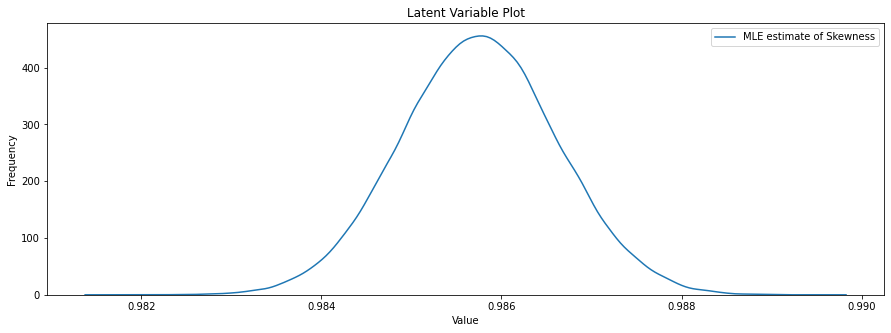

In [1213]:
skewt_model.plot_z([3],figsize=(15,5))

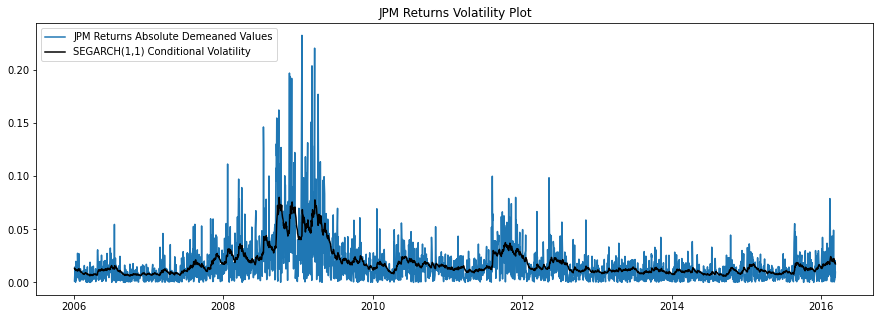

In [1214]:
skewt_model.plot_fit(figsize=(15,5))

In [1222]:
prediction = skewt_model.predict(h=20)

In [1223]:
print(prediction)

            JPM Returns
2016-03-02     0.016882
2016-03-03     0.016871
2016-03-07     0.016840
2016-03-08     0.016834
2016-03-09     0.016814
2016-03-10     0.016791
2016-03-13     0.016782
2016-03-14     0.016754
2016-03-15     0.016734
2016-03-16     0.016716
2016-03-17     0.016713
2016-03-20     0.016701
2016-03-21     0.016691
2016-03-22     0.016684
2016-03-23     0.016677
2016-03-24     0.016665
2016-03-27     0.016671
2016-03-28     0.016677
2016-03-29     0.016660
2016-03-30     0.016658
